## Final Project Submission

Please fill out:
* Student name: Sue Lim
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: Mark Barbour
* Blog post URL: https://medium.com/@limsue9123/assumptions-and-diagnostics-for-linear-regression-bbb2ba25efaf


# I. Data Cleaning & Exploration

In this section, King's county housing data is cleaned by 1) dropping NULL values; 2) transforming the response and the predictor variables as appropriately; and 3) extracting state, county, and zipcode information from the address variable. Additionally, the relationship between the response variable and potentially predictor variables is explored using scatter plots and the correlation matrix.

In [238]:
# Import packages and the house sales data

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

df = pd.read_csv("data/kc_house_data.csv")
df.head()

id        date     price  bedrooms  bathrooms  sqft_living  \
0  7399300360   5/24/2022  675000.0         4        1.0         1180   
1  8910500230  12/13/2021  920000.0         5        2.5         2770   
2  1180000275   9/29/2021  311000.0         6        2.0         2880   
3  1604601802  12/14/2021  775000.0         3        3.0         2160   
4  8562780790   8/24/2021  592500.0         2        2.0         1120   

   sqft_lot  floors waterfront greenbelt nuisance     view condition  \
0      7140     1.0         NO        NO       NO     NONE      Good   
1      6703     1.0         NO        NO      YES  AVERAGE   Average   
2      6156     1.0         NO        NO       NO  AVERAGE   Average   
3      1400     2.0         NO        NO       NO  AVERAGE   Average   
4       758     2.0         NO        NO      YES     NONE   Average   

       grade  heat_source sewer_system  sqft_above  sqft_basement  \
0  7 Average          Gas       PUBLIC        1180              0   
1  7 Average          Oil       PUBLIC        1570           1570   
2  7 Average          Gas       PUBLIC        1580           1580   
3   9 Better          Gas       PUBLIC        1090           1070   
4  7 Average  Electricity       PUBLIC        1120            550   

   sqft_garage  sqft_patio  yr_built  yr_renovated  \
0            0          40      1969             0   
1            0         240      1950             0   
2            0           0      1956             0   
3          200         270      2010             0   
4          550          30      2012             0   

                                             address        lat       long  
0  2102 Southeast 21st Court, Renton, Washington ...  47.461975 -122.19052  
1  11231 Greenwood Avenue North, Seattle, Washing...  47.711525 -122.35591  
2  8504 South 113th Street, Seattle, Washington 9...  47.502045 -122.22520  
3  4079 Letitia Avenue South, Seattle, Washington...  47.566110 -122.29020  
4  2193 Northwest Talus Drive, Issaquah, Washingt...  47.532470 -122.07188

In [239]:
# Drop records containing NULL values

print("Before dropping NULL values: " + str(len(df)) + " records")
df.dropna(axis = 0, inplace = True)
print("After dropping NULL values: " + str(len(df)) + " records")

Before dropping NULL values: 30155 records
After dropping NULL values: 30111 records


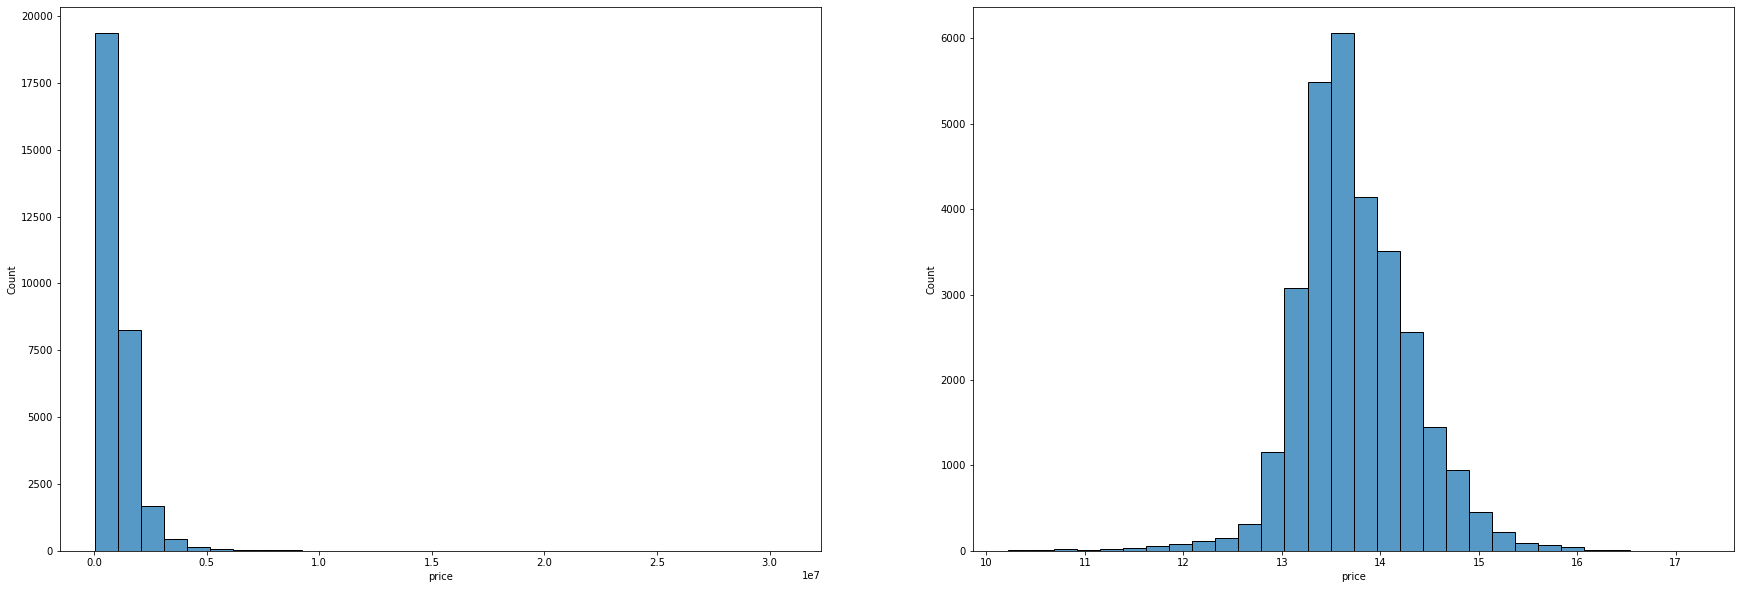

In [144]:
# Plot the distribution of the price variable and the log-transformed price variable
# Use the transformed variable in the regression as it roughly follows the log normal distribution

fig, axes = plt.subplots(ncols = 2, figsize = (30, 10))

sns.histplot(df["price"], bins = 30, ax = axes[0])
sns.histplot(np.log(df["price"]), bins = 30, ax = axes[1]);

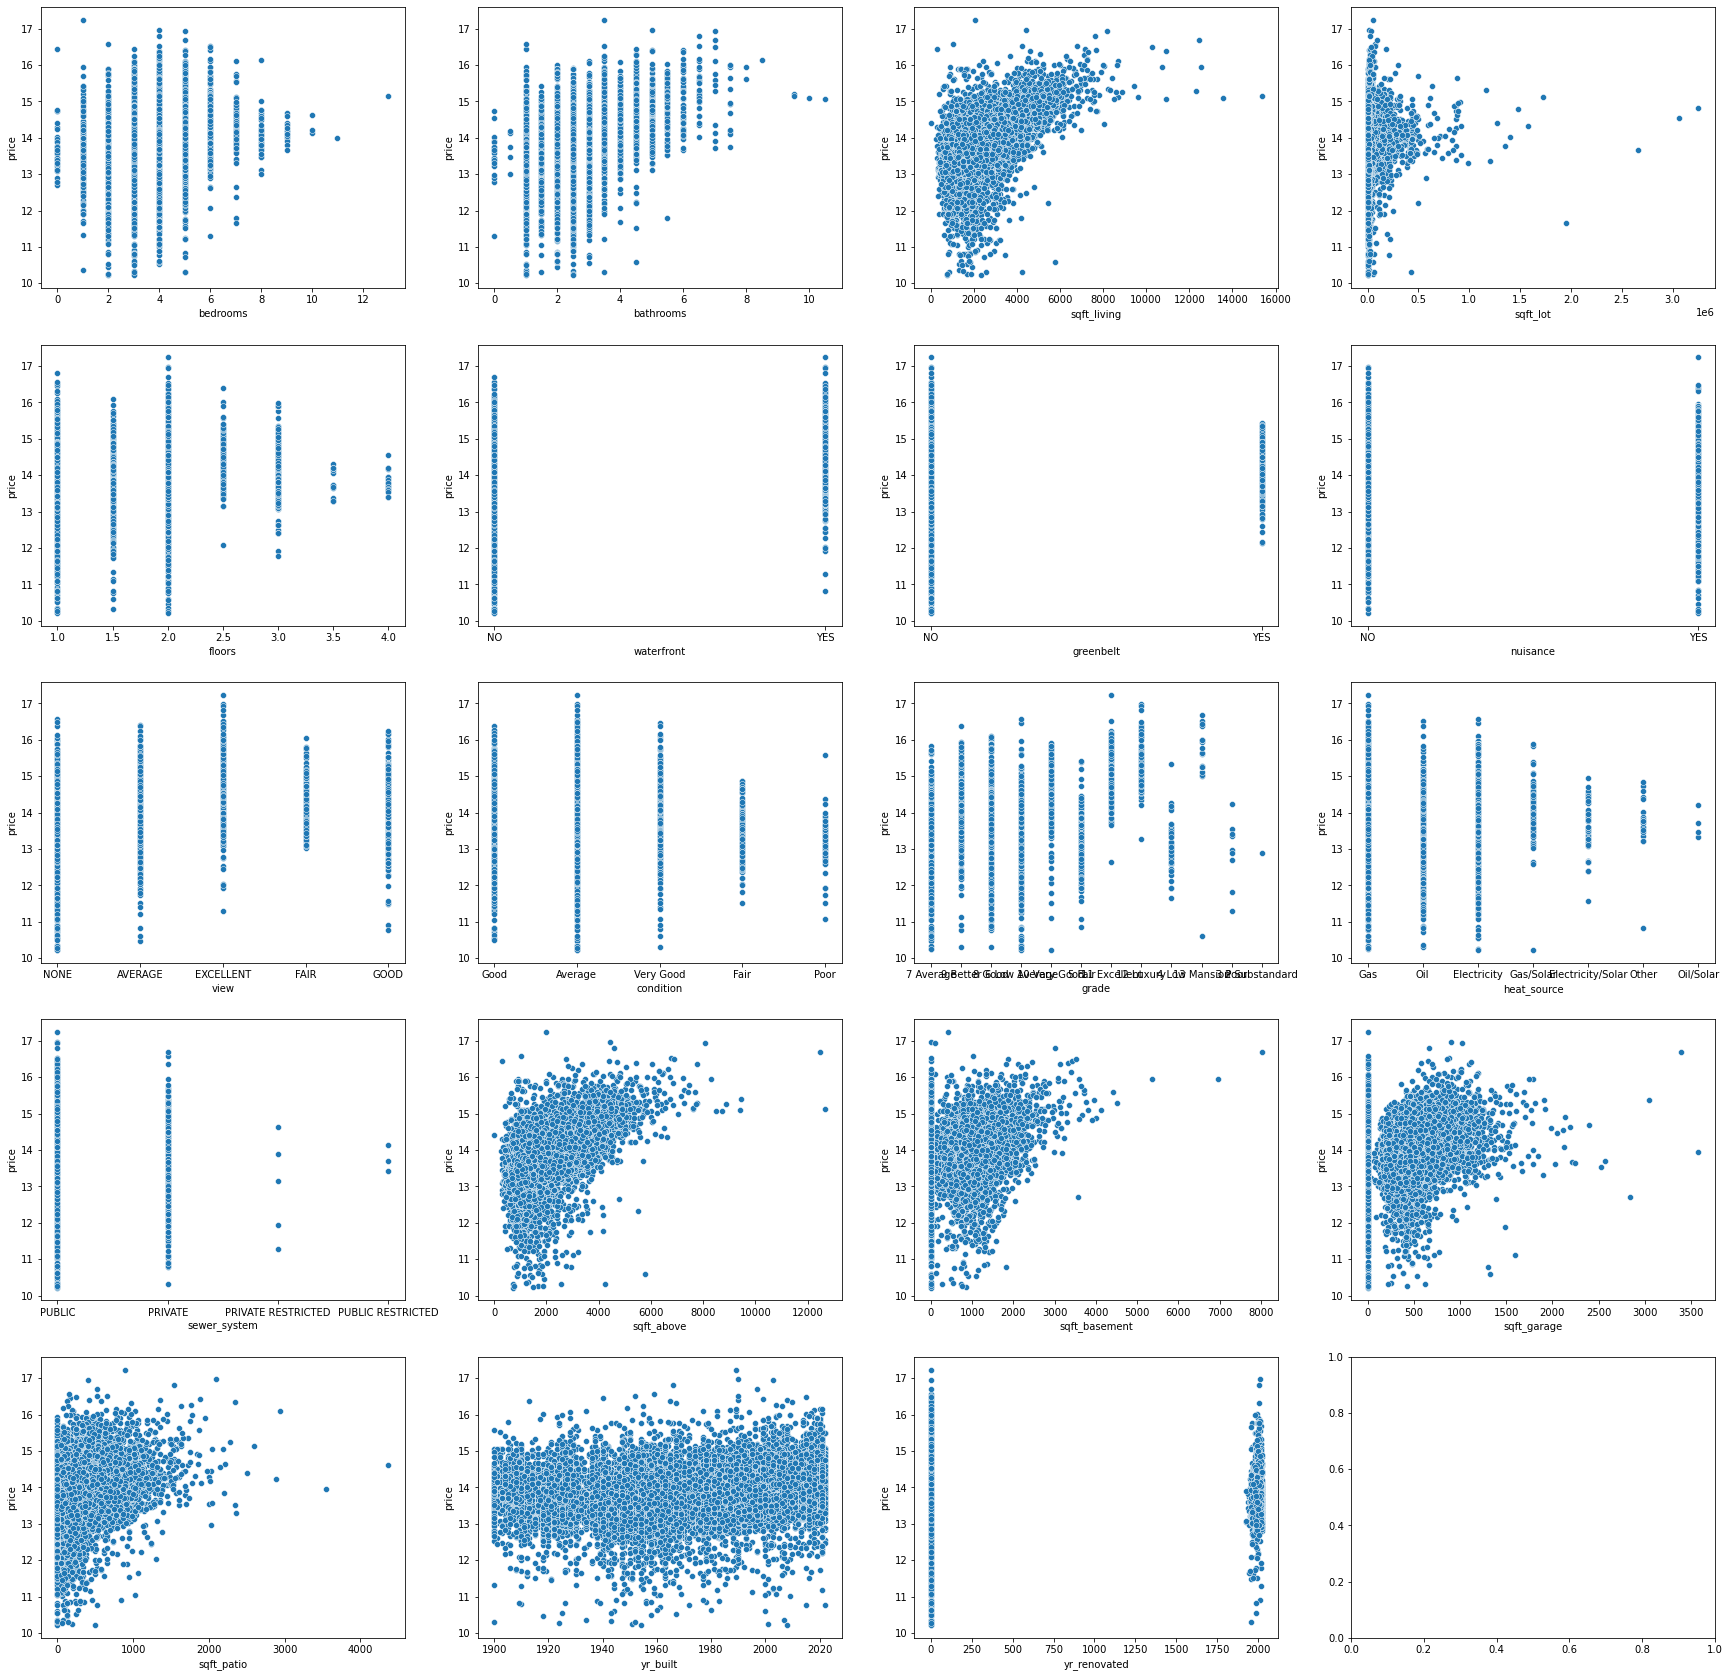

In [202]:
# Plot relationships between the log-transformed price variable and other variables
# (This is not after controlling for all other potential predictor variables but good for preliminary investigation)

fig, axes = plt.subplots(nrows = 5, ncols = 4, figsize = (30, 30))

counter = 0
for i in range(25):
    if (df.columns[i] in ["id", "date", "price", "address", "lat", "long"]) == False:
        sns.scatterplot(x = df.iloc[:, i], y = np.log(df["price"]), ax = axes[np.floor(counter / 4).astype(int), counter % 4])
        counter += 1

In [249]:
# Scrape Zipcode, County, and State from the address variable

df["zipcode"] = df["address"].apply(lambda x: x[-20:-15])
df["county"] = df["address"].str.rsplit(',', 3).apply(lambda x: x[-3][1:])
df["state"] = df["address"].str.rsplit(',', 3).apply(lambda x: x[-2][:-5])

In [250]:
# Clean Zipcode and County further so that the values for which there are less than 30 observations are grouped as Others

df0 = df.copy()

index = df0["zipcode"].value_counts().reset_index()
zipcodes = index[index["zipcode"]>30]
df0["zipcode_clean"] = df0["zipcode"].apply(lambda x: x if x in zipcodes["index"].unique() else "Others")

index = df0["county"].value_counts().reset_index()
counties = index[index["county"]>30]
df0["county_clean"] = df0["county"].apply(lambda x: x if x in counties["index"].unique() else "Others")

In [251]:
# Scrape Transaction Year from the transaction date variable, turn the condition, view, and grade variables into scales
# Take the later of year built and year renovated variables to create a proxy for how modern a home is

df0["yr_transacted"] = df0["date"].apply(lambda x: int(x[-4:])) - 2020
df0["condition"] = df0["condition"].apply(lambda x: 
                                       1 if x == "Poor" else 
                                       (2 if x == "Fair" else 
                                        (3 if x == "Average" else 
                                         (4 if x == "Good" else 5)))) 
df0["view"] = df0["view"].apply(lambda x: 
                                       1 if x == "NONE" else 
                                       (2 if x == "FAIR" else 
                                        (3 if x == "AVERAGE" else 
                                         (4 if x == "GOOD" else 5))))

df0["grade"] = df0["grade"].apply(lambda x: int(x[:2]))

df0["yr_built_renovated"] = df0[["yr_built", "yr_renovated"]].max(axis = 1)

In [252]:
# Filter out outlier records states of which are outside Washington as they are likely to be erroneous records, and
# drop sale prices less than $100K as the data points do not appear to be credible

df1 = df0[(df0["state"] == " Washington ") & (df0["price"]>100000)]

In [254]:
# Log-transform the price variable and create dummy variables and an initial set of predictor variables

y = np.log(df1["price"])

vars_numeric = df1[["sqft_living", "sqft_lot", "yr_transacted", "condition", "view", "grade"]]

vars_character = pd.get_dummies(df1[["waterfront", "greenbelt", "nuisance"]])
vars_character = vars_character[vars_character.columns[vars_character.columns.str.endswith("YES")]]

vars_zipcode = pd.get_dummies(df1[["zipcode_clean"]], drop_first = True)

X = pd.concat([vars_numeric, vars_character, vars_zipcode], axis = 1)

<ipython-input-254-5c65ff91f7cb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vars_numeric["yr_transacted"] = vars_numeric["yr_transacted"]


In [229]:
# Create a correlation matrix to see if there is any pair of variables with correlation > 0.8

pd.concat([y, X], axis = 1).corr()

price  sqft_living  sqft_lot  yr_transacted  \
price                 1.000000     0.624782  0.089709       0.069874   
sqft_living           0.624782     1.000000  0.112429      -0.069349   
sqft_lot              0.089709     0.112429  1.000000      -0.012256   
yr_transacted         0.069874    -0.069349 -0.012256       1.000000   
condition             0.007959    -0.078746 -0.002496      -0.006997   
view                  0.304167     0.222865  0.091828      -0.030081   
grade                 0.602389     0.716924  0.057064      -0.060959   
waterfront_YES        0.189072     0.084669  0.075978      -0.019648   
greenbelt_YES         0.076614     0.100070 -0.019373      -0.004789   
nuisance_YES          0.000427    -0.061318  0.013572      -0.011365   
zipcode_clean_98002  -0.032626    -0.002060 -0.002911       0.024599   
zipcode_clean_98003  -0.053847     0.025096 -0.002806       0.011333   
zipcode_clean_98004   0.268732     0.133931 -0.007348       0.001748   
zipcode_clean_98005   0.110028     0.048358  0.002889       0.001461   
zipcode_clean_98006   0.132601     0.084461 -0.010847      -0.016571   
zipcode_clean_98007   0.026746    -0.011713 -0.008627      -0.005270   
zipcode_clean_98008   0.056714    -0.020207 -0.018025      -0.008218   
zipcode_clean_98010  -0.058178     0.053422 -0.003311       0.000867   
zipcode_clean_98011   0.003295     0.004820 -0.011322       0.000169   
zipcode_clean_98014  -0.016398     0.015666  0.098145       0.004200   
zipcode_clean_98019  -0.039127     0.001748  0.060242      -0.001118   
zipcode_clean_98022  -0.055894     0.015632  0.219578      -0.003542   
zipcode_clean_98023  -0.081186     0.040437 -0.000340       0.029509   
zipcode_clean_98024   0.027305     0.017299  0.081419       0.030144   
zipcode_clean_98027   0.039548     0.038487  0.043445       0.002285   
zipcode_clean_98028  -0.015692     0.000531 -0.009930      -0.007780   
zipcode_clean_98029   0.060537     0.027429 -0.013804      -0.016121   
zipcode_clean_98030  -0.080244     0.008766 -0.007678       0.020211   
zipcode_clean_98031  -0.094248     0.004948 -0.008830       0.005794   
zipcode_clean_98032  -0.033355     0.004723  0.053132       0.020132   
zipcode_clean_98033   0.174410     0.034468 -0.021547      -0.019865   
zipcode_clean_98034   0.018516    -0.036676 -0.023546      -0.004772   
zipcode_clean_98038  -0.101683     0.021914  0.030311       0.003330   
zipcode_clean_98039   0.154244     0.070866 -0.001130      -0.006647   
zipcode_clean_98040   0.207090     0.124329 -0.008016      -0.019539   
zipcode_clean_98042  -0.124529     0.040399  0.024735       0.037680   
zipcode_clean_98045  -0.017442     0.032625  0.038664       0.005024   
zipcode_clean_98047  -0.018015    -0.003097 -0.002146       0.000493   
zipcode_clean_98051  -0.006185     0.023914  0.102779       0.001918   
zipcode_clean_98052   0.088169     0.005317 -0.014606      -0.014801   
zipcode_clean_98053   0.071475     0.054341  0.072828      -0.011042   
zipcode_clean_98055  -0.063956    -0.006490 -0.008263      -0.003912   
zipcode_clean_98056  -0.018562     0.004164 -0.017346       0.004304   
zipcode_clean_98057  -0.031572     0.004568 -0.006090       0.016396   
zipcode_clean_98058  -0.099911     0.006346 -0.004280      -0.001124   
zipcode_clean_98059  -0.027033     0.031377  0.019074      -0.008033   
zipcode_clean_98065   0.002845     0.026759 -0.003524       0.013066   
zipcode_clean_98070  -0.011196    -0.021670  0.103925      -0.015459   
zipcode_clean_98072   0.045714     0.040643  0.031484      -0.018074   
zipcode_clean_98074   0.097953     0.062723 -0.001618      -0.011020   
zipcode_clean_98075   0.134294     0.114494 -0.005301      -0.020705   
zipcode_clean_98077   0.062574     0.070545  0.073083      -0.005155   
zipcode_clean_98092  -0.094305     0.045757  0.082165       0.012161   
zipcode_clean_98102   0.039823     0.000562 -0.018630      -0.009675   
zipcode_clean_98103  -0.038076    -0.118217 -0.042147       0.005

# II. Regression Result & Model Selection

I run three different potential models to see which one performs the best. The first model uses zipcodes as dummy variables as well as other predictor variables, the second model uses counties instead. The third model does not use either zipcodes or counties. Among them, I pick the first model as the R-squared is highest and AIC & BIC are the lowest.

In [240]:
# Initial regression model and result

model = sm.OLS(y, sm.add_constant(X))
results = model.fit(cov_type='HC3')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     682.5
Date:                Sat, 29 Apr 2023   Prob (F-statistic):               0.00
Time:                        15:53:13   Log-Likelihood:                 2126.5
No. Observations:               21845   AIC:                            -4087.
Df Residuals:                   21762   BIC:                            -3424.
Df Model:                          82                                         
Covariance Type:                  HC3                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   12.0408 

In [209]:
# Second regression model and result using County instead of Zipcode

vars_county = pd.get_dummies(df1[["county_clean"]], drop_first = True)
X_2 = pd.concat([vars_numeric, vars_character, vars_county], axis = 1)

model_2 = sm.OLS(y, sm.add_constant(X_2))
results_2 = model_2.fit(cov_type = "HC3")
print(results_2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     1378.
Date:                Sat, 29 Apr 2023   Prob (F-statistic):               0.00
Time:                        12:21:05   Log-Likelihood:                -6541.8
No. Observations:               29116   AIC:                         1.318e+04
Df Residuals:                   29069   BIC:                         1.357e+04
Df Model:                          46                                         
Covariance Type:                  HC3                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [210]:
# Third regression model and result using neither Zipcode nor County

X_3 = pd.concat([vars_numeric, vars_character], axis = 1)

model_3 = sm.OLS(y, sm.add_constant(X_3))
results_3 = model_3.fit(cov_type = "HC3")
print(results_3.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     2610.
Date:                Sat, 29 Apr 2023   Prob (F-statistic):               0.00
Time:                        12:21:05   Log-Likelihood:                -14303.
No. Observations:               29116   AIC:                         2.863e+04
Df Residuals:                   29106   BIC:                         2.871e+04
Df Model:                           9                                         
Covariance Type:                  HC3                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             11.3784      0.027    414.

In [108]:
# Plot partial regression plot to diagnose the effect of of each predictor variable after controlling for other variables

fig, ax = plt.subplots(figsize = (25, 500))
sm.graphics.plot_partregress_grid(results, fig = fig)
plt.show()

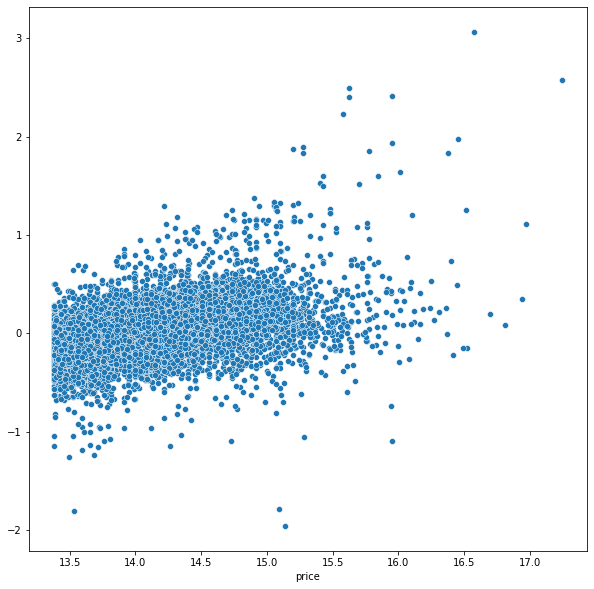

In [232]:
# Plot error terms for diagnostics

fig, ax = plt.subplots(figsize = (10, 10))
sns.scatterplot(x = y, y = results.resid, ax = ax);